In [1]:
import os

import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
import numpy as np
import seaborn as sns

from REStats.utils import load_SCADA, filter_outliers
from REStats.plots import save_figs

In [2]:
sns.set_theme()

In [3]:
wt = load_SCADA(2020)

In [9]:
wt_train = wt[["wind_speed", "power"]]
wt_train = wt_train.resample("H").mean()
wt_train.head()

,wind_speed,power
Date,,
2020-01-01 00:00:00,3.867503,145.013856
2020-01-01 01:00:00,5.663008,411.687777
2020-01-01 02:00:00,4.896892,253.356735
2020-01-01 03:00:00,5.320999,266.979956
2020-01-01 04:00:00,4.438020,155.545291


In [10]:
def filter_outliers(group):
    q1 = group.power.quantile(.25)
    q3 = group.power.quantile(.75)
    iqr = q3 - q1
    filtered = group.query('(@q1 - 1.5 * @iqr) <= power <= (@q3 + 1.5 * @iqr)')
    return filtered
    
wt_bins = np.arange(0, 25, .5)
wt_groups = ws.groupby(pd.cut(wt_train.wind_speed, wt_bins))
wt_filtered = wt_groups.apply(filter_outliers)
wt_filtered.index = wt_filtered.index.droplevel()
wt_filtered = wt_filtered.sort_index()
wt_filtered.head()

,wind_speed,power
Date,,
2020-01-01 00:00:00,3.867503,145.013856
2020-01-01 01:00:00,5.663008,411.687777
2020-01-01 02:00:00,4.896892,253.356735
2020-01-01 03:00:00,5.320999,266.979956
2020-01-01 04:00:00,4.438020,155.545291


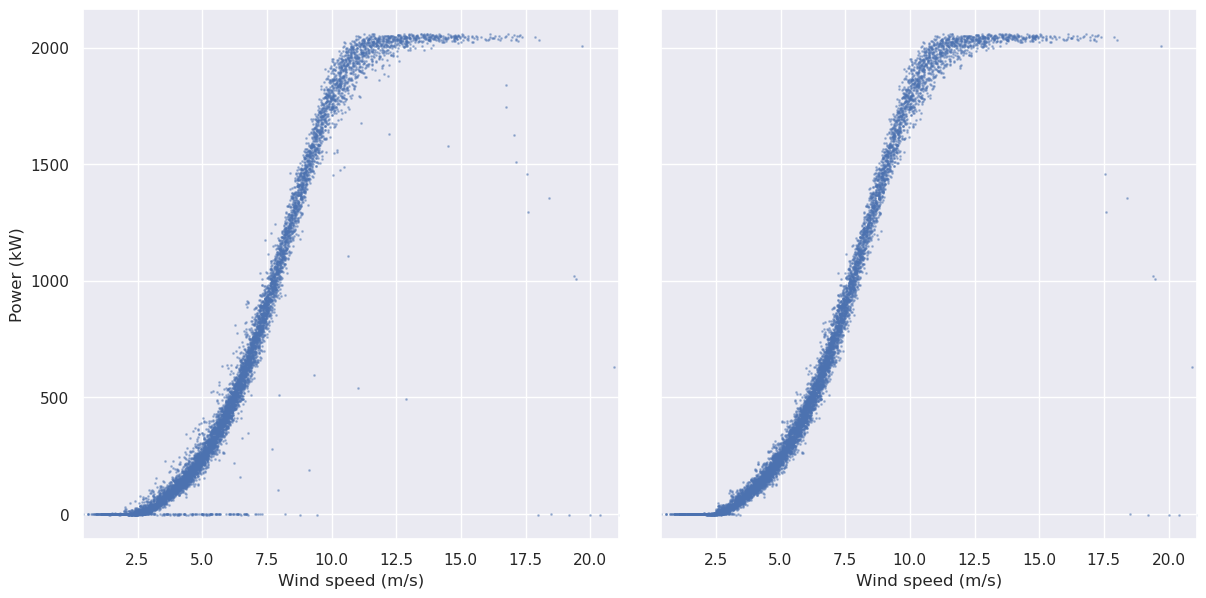

In [13]:
filtered_pc, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
filtered_pc.tight_layout()
axes[0].set_ylabel("Power (kW)")
for ax in axes:
    ax.set_xmargin(0)
    ax.set_xlabel("Wind speed (m/s)")

axes[0].scatter(wt_train.wind_speed, wt_train.power, s=1, alpha=0.4)
axes[1].scatter(wt_filtered.wind_speed, wt_filtered.power, s=1, alpha=0.4)

In [167]:
wt.head()

,Power,Wind direction,Wind speed
Date,,,
2020-01-01 00:00:00,150.984141,116.839462,3.887291
2020-01-01 00:10:00,130.414782,115.659361,3.848941
2020-01-01 00:20:00,146.401656,116.646515,4.043625
2020-01-01 00:30:00,84.296224,111.157642,3.330342
2020-01-01 00:40:00,94.994105,116.678227,3.388536


In [220]:
X = wt_sample["Wind speed"].values[:, None]
y = wt_sample["Power"].values
y_mean = y.mean()

with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)
    cov_func = η**2 * pm.gp.cov.ExpQuad(1, ls=ℓ)
    gp = pm.gp.Marginal(cov_func=cov_func)
    sigma = pm.HalfCauchy("sigma", beta=5)
    
    y_ = gp.marginal_likelihood("y", X=X, y=y-y_mean, sigma=sigma)
    
    idata = pm.sample(chains=2, cores=1)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ℓ, η, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 67 seconds.


In [221]:
Xnew = np.linspace(0, 20, 100)[:, None]

with model:
    fnew = gp.conditional("fnew", Xnew=Xnew)

In [222]:
with model:
    ppc = pm.sample_posterior_predictive(idata, var_names=["fnew"])

Sampling: [fnew]


array([[<Axes: title={'center': 'ℓ'}>, <Axes: title={'center': 'ℓ'}>],
       [<Axes: title={'center': 'η'}>, <Axes: title={'center': 'η'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

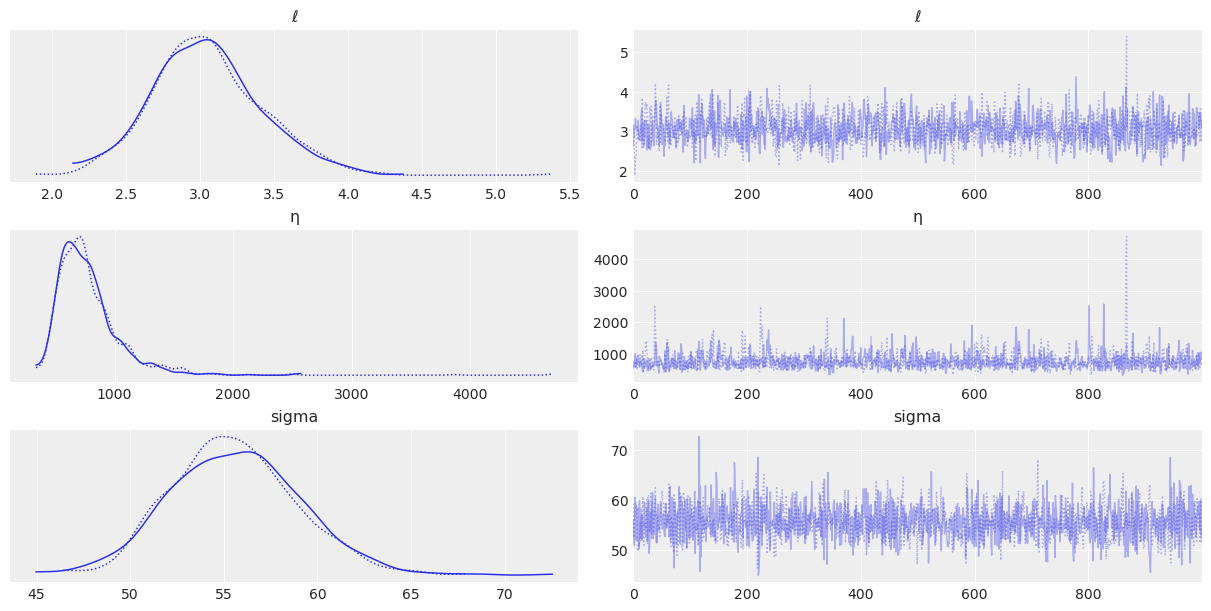

In [223]:
az.plot_trace(idata)

In [224]:
ppc.posterior_predictive.fnew[0]

<xarray.DataArray 'fnew' (draw: 1000, fnew_dim_2: 100)>
array([[-776.22570537, -787.9450326 , -795.90597725, ...,  729.89525394,
         657.0712325 ,  580.30980918],
       [-929.632293  , -899.63068291, -872.76158015, ...,  389.94866318,
         362.83780192,  338.72830057],
       [-608.2621985 , -631.82729397, -655.36679701, ...,  -65.7791676 ,
        -136.57362334, -202.72145018],
       ...,
       [-549.03376267, -586.2186276 , -619.91807867, ..., 1228.02228719,
        1210.10326675, 1189.89031363],
       [-735.51153982, -744.3905284 , -752.89242652, ...,   13.50387529,
         -54.73074421, -119.39001845],
       [-747.51674509, -763.1672822 , -776.33412874, ...,  831.36961588,
         784.45817236,  736.02089113]])
Coordinates:
    chain       int64 0
  * draw        (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * fnew_dim_2  (fnew_dim_2) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99

Text(0, 0.5, 'Power (kW)')

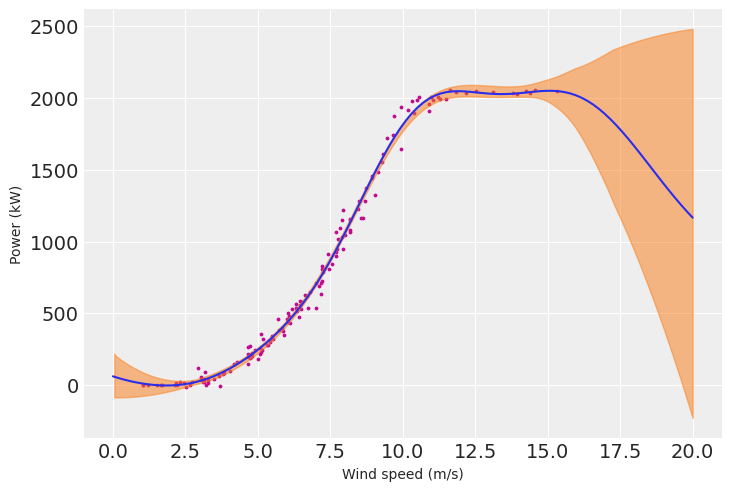

In [226]:
fig, ax = plt.subplots()

y_pred = ppc.posterior_predictive.fnew.mean(["chain", "draw"])

ax.plot(Xnew, y_pred + y_mean, color="C0")
ax.scatter(wt_sample["Wind speed"], y, s=3, color="C3")
az.plot_hdi(Xnew.flatten(), ppc.posterior_predictive.fnew + y_mean)

ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Power (kW)")